In [38]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Logistic regression
Sources: 
- [sklearn model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [wiki](https://en.wikipedia.org/wiki/Logistic_regression)
- [MLMastery](https://machinelearningmastery.com/logistic-regression-for-machine-learning/)

## Simple example
Let's generate dataset first

In [39]:
def gen_example(lb: int, size: int, mult: int) -> pd.DataFrame:
    """
    Generates simple example DataFrame with x ft and y target
    Parameters:
    lb (int): lower boundary of x
    size (int): category size (dataset size = 2*size)
    mult (int): multiplier
    Returns:
    X (pd.DataFrame): dataset
    """
    x_values = np.concatenate((np.random.rand(size)*mult-lb, \
        np.random.rand(size)*mult), axis=0)    # array
    y_values = np.array([0]*size+[1]*size)  # labels array
    X = pd.DataFrame({'x': x_values, 'y': y_values})    # DataFrame
    return X

def plot_dataset(dataset: pd.DataFrame) -> None:
    """
    Plots dataset
    Parameters:
    dataset (pd.DataFrame): input DataFrame
    """
    plt.scatter(dataset.loc[dataset.y==0, 'x'], dataset.loc[dataset.y==0, 'y'], label=0)    # scatter first class
    plt.scatter(dataset.loc[dataset.y==1, 'x'], dataset.loc[dataset.y==1, 'y'], label=1)    # scatter second class
    plt.legend()
    plt.show()   

In [40]:
lb, size, mult = 15, 15, 10
X = gen_example(lb, size, mult)
X.sample(7) # sample data

,x,y
24,0.462597,1
18,7.075534,1
22,9.320137,1
20,9.811468,1
8,-7.408696,0
19,4.334007,1
4,-5.234742,0


## Visualization
Plot the data

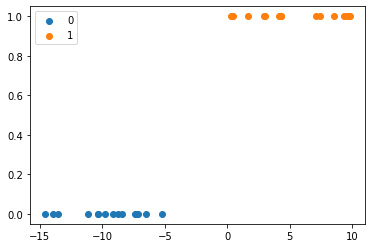

In [41]:
plot_dataset(X)

In [42]:
lb, size, mult = 7, 20, 10  # Keep calm and play around with different parameters :D
train_set = gen_example(lb, size, mult)
test_set = gen_example(lb, size//2, mult)

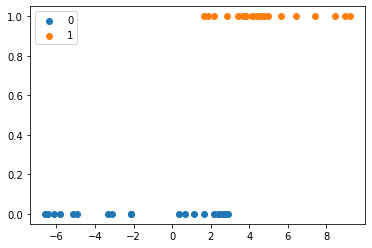

In [43]:
plot_dataset(train_set)

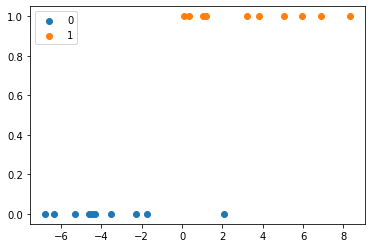

In [44]:
plot_dataset(test_set)

I kept getting annoyed by all this `dataset.x.values.reshape(-1, 1)` stuff so here are some cool functions

In [45]:
def get_x(dataset, target='y'):
    """
    Fixes annoying dimensionality issue with LogisticRegression
    """
    if isinstance(dataset, np.ndarray) and len(dataset.shape) == 1:
        return dataset.reshape(-1, 1)
    if isinstance(dataset, pd.Series):
        return dataset.values.reshape(-1, 1)
    cols = [col for col in dataset.columns if col != target]
    if len(cols) == 1:
        return dataset.loc[:, cols].values.reshape(-1, 1)
    return dataset.loc[:, cols]

def get_y(dataset, target='y'):
    return dataset.loc[:, target]

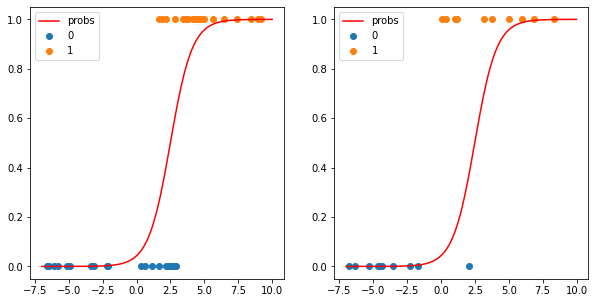

In [46]:
model = LogisticRegression()    # define the model
model.fit(get_x(train_set, 'y'), train_set.y)   # fit model
X_test = np.linspace(-lb, mult, 1000)   # logistic regression plot x values
y_pred = model.predict_proba(get_x(X_test))[:, 1]   # model output
# here we use model.predict_proba instead of model.predict to get probabilities
# at every point in X_test array instead of [0, 1]^(size*2) vector
_, axs = plt.subplots(1, 2, figsize=(10, 5))    # this trick enables us to plot two charts at once
for idx, dataset in enumerate((train_set, test_set)):
    # axs is just an array of ax objects, thus we can access them via a standard indexing
    axs[idx].plot(X_test, y_pred, color='red', label='probs')    # plot the curve
    axs[idx].scatter(dataset.loc[dataset.y==0, 'x'], dataset.loc[dataset.y==0, 'y'], label=0)
    axs[idx].scatter(dataset.loc[dataset.y==1, 'x'], dataset.loc[dataset.y==1, 'y'], label=1)
    # and the data
    axs[idx].legend()   # show the labels
plt.show()

### Once we've got all of this covered let'c compile it into one function

In [47]:
def do_everything(lb: int, size: int, mult: int, model) -> tuple:
    """
    Generates example train and test DataFrames with x ft and y target
    Plots them
    Trains model and returns datasets and model
    Parameters:
    lb (int): lower boundary of x
    size (int): category size (dataset size = 2*size)
    mult (int): multiplier
    model: ML model instance
    Returns:
    train_set (pd.DataFrame), test_set (pd.DataFrame), model: datasets, trained model
    """
    train_set = gen_example(lb, size, mult)
    test_set = gen_example(lb, size//2, mult)
    print('train_set')
    plot_dataset(train_set)
    print('test_set')
    plot_dataset(test_set)
    model.fit(get_x(train_set, 'y'), train_set.y)
    X_test = np.linspace(-lb, mult, 1000)
    y_pred = model.predict_proba(get_x(X_test))[:, 1]
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    for idx, dataset in enumerate((train_set, test_set)):
        axs[idx].plot(X_test, y_pred, color='red', label='probs')
        axs[idx].scatter(dataset.loc[dataset.y==0, 'x'], dataset.loc[dataset.y==0, 'y'], label=0)
        axs[idx].scatter(dataset.loc[dataset.y==1, 'x'], dataset.loc[dataset.y==1, 'y'], label=1)
        axs[idx].legend()
    plt.show()
    return train_set, test_set, model

# Confusion Matrix
Source: 
- [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
- [CM How-To](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

Annotations:
- TN = True Negative (true value is 0 and model predicts 0)
- FN = False Negative (true value is 1 and model predicts 0)
- TP = True Positive (true value is 1 and model predicts 1)
- FP = False Positive (true value is 0 and model predicts 1)

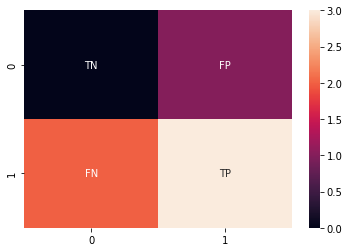

In [48]:
from seaborn import heatmap
heatmap([[0, 1], [2, 3]], annot=[['TN', 'FP'], ['FN', 'TP']], fmt='')
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix
y_pred_train = model.predict(get_x(train_set, 'y')) # predicted labels array (train_set)
y_pred_test = model.predict(get_x(test_set, 'y'))   # predicted labels array (test_set)
cm_train = confusion_matrix(train_set.y, y_pred_train)  # confusion matrix train_set
cm_test = confusion_matrix(test_set.y, y_pred_test)     # confusion matrix test_set
cm_train, cm_test   # print

(array([[17,  3],
        [ 3, 17]], dtype=int64),
 array([[10,  0],
        [ 4,  6]], dtype=int64))

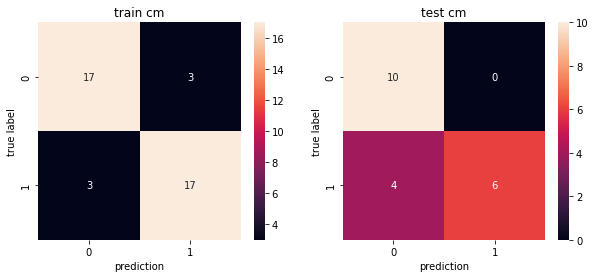

In [50]:
_, axs = plt.subplots(1, 2, figsize=(10, 4))    # same trick as before
heatmap(cm_train, annot=True, ax=axs[0])    # we can pass ax object as a parameter to the heatmap
heatmap(cm_test, annot=True, ax=axs[1])     # to plot it on a dedicated subplot
axs[0].set_title('train cm')    # setting title
axs[1].set_title('test cm')
for idx in (0, 1):
    axs[idx].set_xlabel('prediction')
    axs[idx].set_ylabel('true label')
plt.show()

# Metrics

## The most important ones: [wiki](https://en.wikipedia.org/wiki/Precision_and_recall)
- [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) = (TP+TN)/(TP+TN+FP+FN)
- [precision](https://www.google.com/search?q=precision+sklearn&oq=precision+sklearn&aqs=chrome..69i57j0i22i30l9.1827j0j4&sourceid=chrome&ie=UTF-8) = TP/(TP+FP)
- [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) = TP/(TP+FN)
- [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) = 2*(precision*recall)/(precision+recall)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_train = model.predict(get_x(train_set, 'y'))
y_pred_test = model.predict(get_x(test_set, 'y'))
print('Training set')
print('Accuracy:', accuracy_score(test_set.y, y_pred_test))
print('Precision:', precision_score(test_set.y, y_pred_test))
print('Recall:', recall_score(test_set.y, y_pred_test))
print('F1 score:', f1_score(test_set.y, y_pred_test))

Training set
Accuracy: 0.8
Precision: 1.0
Recall: 0.6
F1 score: 0.7499999999999999


### Once again compilation function

In [52]:
def show_metrics(model, dataset, target='y'):
    """
    Prints out the most important metrics
    """
    is_binary = max(get_y(dataset, target)) == 1
    avg = 'binary' if is_binary else 'macro'
    y_pred = model.predict(get_x(dataset, target))
    heatmap(confusion_matrix(get_y(dataset, target), y_pred), annot=True, fmt='d')
    plt.show()
    print('Accuracy:', accuracy_score(get_y(dataset, target), y_pred))
    print('Precision:', precision_score(get_y(dataset, target), y_pred, average=avg))
    print('Recall:', recall_score(get_y(dataset, target), y_pred, average=avg))
    print('F1 score:', f1_score(get_y(dataset, target), y_pred, average=avg))

## The less-obvious ones: 
- [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
- [Plotting the ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [More info](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

To show these metrics at their best we need bigger datasets

train_set


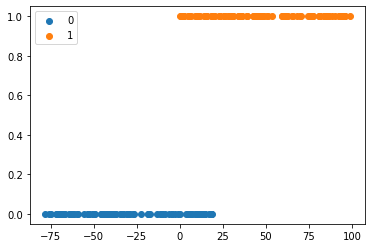

test_set


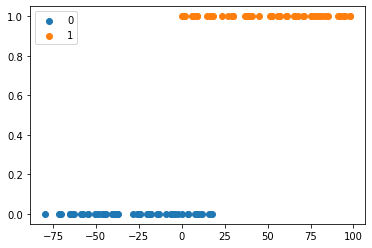

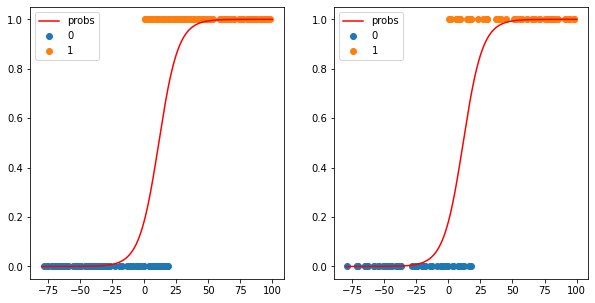

In [53]:
lb, size, mult = 80, 100, 100   # bigger dataset
model = LogisticRegression()
train_set, test_set, model = do_everything(lb, size, mult, model)

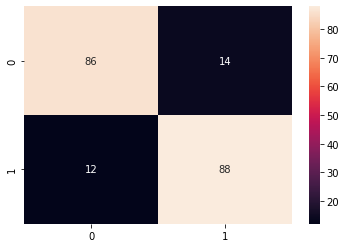

Accuracy: 0.87
Precision: 0.8627450980392157
Recall: 0.88
F1 score: 0.8712871287128714


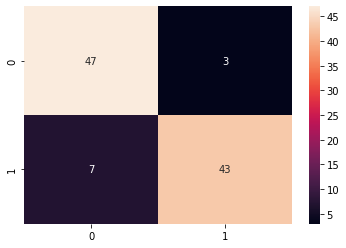

Accuracy: 0.9
Precision: 0.9347826086956522
Recall: 0.86
F1 score: 0.8958333333333334


(None, None)

In [54]:
show_metrics(model, train_set), show_metrics(model, test_set)

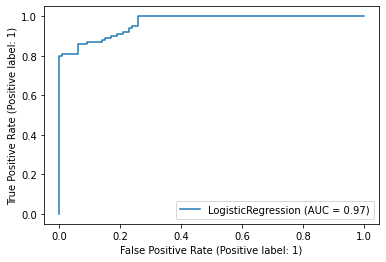

Area Under the ROC Curve score: 0.9674


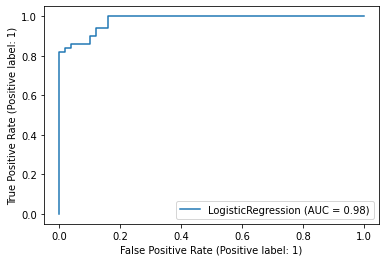

Area Under the ROC Curve score: 0.9803999999999999


In [55]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
RocCurveDisplay.from_estimator(model, get_x(train_set, 'y'), train_set.y)   # roc curve
plt.show()
y_true = train_set.y
y_proba = model.predict_proba(get_x(train_set, 'y'))[:, 1]  # probabilites output
print('Area Under the ROC Curve score:', roc_auc_score(y_true, y_proba))    # auc score
RocCurveDisplay.from_estimator(model, get_x(test_set, 'y'), test_set.y)
y_true = test_set.y
y_proba = model.predict_proba(get_x(test_set, 'y'))[:, 1]
plt.show()
print('Area Under the ROC Curve score:', roc_auc_score(y_true, y_proba))

# But why all of the above even matter? Imbalanced datasets case study

## Let's implement a pretty useless model
It literally does nothing

In [56]:
class DumbModel():
    """
    Example class to show how does the imbalance issue work
    """
    def __init__(self):
        self._estimator_type = 'classifier'
        self.classes_ = [0, 1]
        print('DumbModel()')    # just to mimic LogisticRegression

    def fit(self, X, y):
        pass    # xD

    def predict(self, X):
        return np.zeros(X.shape[0])
    
    def predict_proba(self, X):
        return np.array([[1, 0]]*X.shape[0])

In [57]:
dumb_model = DumbModel()
dumb_model.fit(get_x(train_set, 'y'), train_set.y)  # yeah, ""fitting""
print('DumbModel\'s predictions:', dumb_model.predict(get_x(test_set, 'y')[45:55]))
print('A proper model\'s predictions:', model.predict(get_x(test_set, 'y')[45:55]))

DumbModel()
DumbModel's predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
A proper model's predictions: [0 0 0 0 0 1 1 0 1 1]


train_set


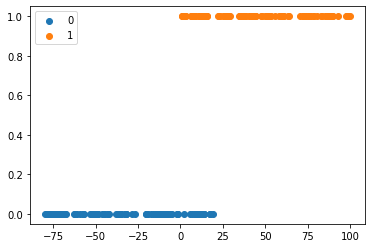

test_set


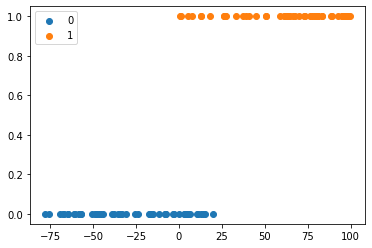

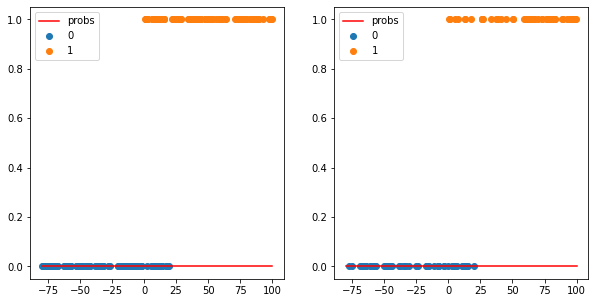

In [58]:
train_set, test_set, dumb_model = do_everything(lb, size, mult, dumb_model) # performance on a similar dataset

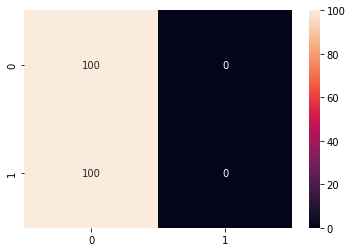

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 score: 0.0


In [59]:
show_metrics(dumb_model, train_set) # metrics

Pretty stupid, isn't it?
## But then, let's create a new dataset

DumbModel()


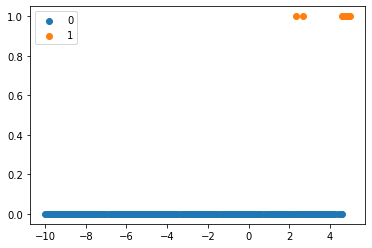

In [60]:
def get_imbalanced_sample(size, mult, lb, ratio):
    """
    Generates a dataset with a defined ratio between True and False labels
    """
    new_x = np.random.rand(size)*mult-lb
    new_y = (new_x >= sorted(new_x)[-int(ratio*size)])|(np.random.rand(size) < ratio/5)
    imbalanced_dataset = pd.DataFrame({'x': new_x, 'y': new_y})
    return imbalanced_dataset

imbalanced_dataset = get_imbalanced_sample(400, 15, 10, 0.02)
dumb_model = DumbModel()
plot_dataset(imbalanced_dataset)    # nice

## And use our DumbModel to run predictions on it

In [61]:
from sklearn.model_selection import train_test_split    # finally a proper approach :D
X_train, X_test, y_train, y_test = train_test_split(imbalanced_dataset.x, imbalanced_dataset.y, test_size=0.5)
dumb_model.fit(X_train, y_train)
model.fit(get_x(X_train), y_train)

LogisticRegression()

## And score it with just an accuracy score

In [62]:
y_pred = dumb_model.predict(X_test)
print('DumbModel accuracy score:', accuracy_score(y_test, y_pred))
y_pred = model.predict(get_x(X_test))
print('LogisticRegression accuracy score:', accuracy_score(y_test, y_pred))

DumbModel accuracy score: 0.97
LogisticRegression accuracy score: 0.97


## Surprise surprise!

## Let's now behave like pro and check the other metrics

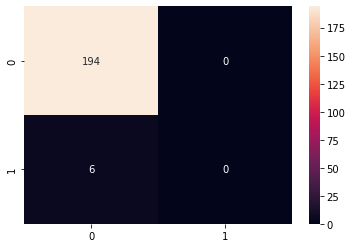

Accuracy: 0.97
Precision: 0.0
Recall: 0.0
F1 score: 0.0


In [63]:
test_dataset = pd.DataFrame({'x': X_test, 'y': y_test})
show_metrics(dumb_model, test_dataset)

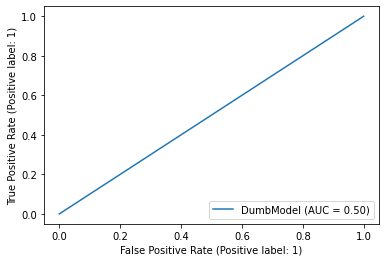

Area Under the ROC Curve score: 0.5


In [64]:
RocCurveDisplay.from_estimator(dumb_model, get_x(test_dataset, 'y'), test_dataset.y)
plt.show()
y_true = test_dataset.y
y_proba = dumb_model.predict_proba(get_x(test_dataset, 'y'))[:, 1]
print('Area Under the ROC Curve score:', roc_auc_score(y_true, y_proba))

## What appears to have happened? :D
((protip: accuracy metric for this case is  *`u s e l e s s`*))

## Let's compile all of this into a one function again, now featuring comparison between models' performance

In [65]:
def compare_models(model_one, model_two, dataset, target='y'):
    def calculate_metrics(model, dataset, model_name, dataset_name):
        # util func returning a DF with metrics wrt model, dataset
        y_pred = model.predict(get_x(dataset, target))
        y_true = get_y(dataset, target)
        scores = [accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, average='macro'), \
            recall_score(y_true, y_pred, average='macro'), f1_score(y_true, y_pred, average='macro')]
        return pd.DataFrame({'model': [model_name]*4, 'dataset': [dataset_name]*4,\
            'metric': ['accuracy', 'precision', 'recall', 'f1'], 'value': scores})

    def plot_datasets(train, test):
        # util func for logistic reg dataset plots
        print('train set')
        plot_dataset(train)
        print('test set')
        plot_dataset(test)
    
    def plot_probas(ds, model, axs):
        # util func for logistic reg line plots
        axs[y_idx][x_idx].scatter(ds.loc[ds.y==0, 'x'].values, ds.loc[ds.y==0, 'y'].values, label=0)
        axs[y_idx][x_idx].scatter(ds.loc[ds.y==1, 'x'].values, ds.loc[ds.y==1, 'y'].values, label=1)
        x = np.linspace(ds.x.min(), ds.x.max(), 1000)
        y_score = model.predict_proba(get_x(x))[:, 1]
        axs[y_idx][x_idx].plot(x, y_score, color='red', label='probs')
        axs[y_idx][x_idx].legend()
        axs[y_idx][x_idx].set_title(model_name+' on '+ds_name)
    
    def plot_heatmaps(model, ds, ht_axs):
        # util func for heatmap plotting
        y_pred = model.predict(get_x(ds, target))
        heatmap(confusion_matrix(get_y(ds, target), y_pred), annot=True, ax=ht_axs[y_idx][x_idx], fmt='d')
        ht_axs[y_idx][x_idx].set_title(model_name+' on '+ds_name)

    is_log_reg = True if target=='y' else False # in a couple of minutes we'll see why this is crucial
    cols = [col for col in dataset.columns if col!=target]  # same here
    X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, cols], get_y(dataset, target), test_size=0.4, random_state=2664)
    train_dataset = pd.concat((X_train, y_train), axis=1)
    test_dataset = pd.concat((X_test, y_test), axis=1)
    model_one.fit(get_x(X_train, target), y_train)
    model_two.fit(get_x(X_train, target), y_train)
    if is_log_reg:  # here we go
        plot_datasets(train_dataset, test_dataset)
        _, axs = plt.subplots(2, 2, figsize=(10, 10))   # probabilities plots per model, dataset
        _, roc_axs = plt.subplots(2, 2, figsize=(10, 10))   # ROC curve per model, dataset
    _, ht_axs = plt.subplots(2, 2, figsize=(10, 10))   # heatmaps per model, dataset
    metrics_df = pd.DataFrame(columns=['model', 'dataset', 'metric', 'value'])
    print('Models predictions')
    # iterate over datasets
    for y_idx, d in enumerate(((train_dataset, 'train'), (test_dataset, 'test'))):
        ds, ds_name = d
        # and models
        for x_idx, m in enumerate(((model_one, 'one'), (model_two, 'two'))):
            model, model_name = m
            if is_log_reg:
                # -------probabilities section----------
                plot_probas(ds, model, axs)
                # -------ROC curves section--------
                RocCurveDisplay.from_estimator(model, get_x(ds, target), ds.y, ax=roc_axs[y_idx][x_idx])
            # -------heatmaps section-----------
            plot_heatmaps(model, ds, ht_axs)
            metrics_df = pd.concat((metrics_df, calculate_metrics(model, ds, model_name, ds_name)))
    _, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for idx, ds_name in enumerate(('train', 'test')):
        # yeah, I know it's magic, but digging down into pandas 
        # can reveal what on earth is going on in here xD
        metrics_df.loc[metrics_df.dataset==ds_name, :].groupby(['model', 'metric']).value.agg(lambda x: x)\
            .unstack(level=0).plot(kind='bar', subplots=False, ax=axs[idx], title=ds_name)
        # (((worth it)))
    plt.show()

train set


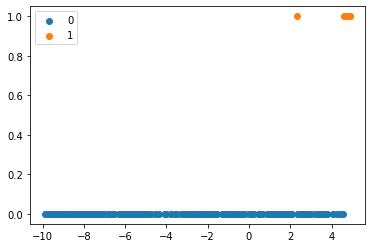

test set


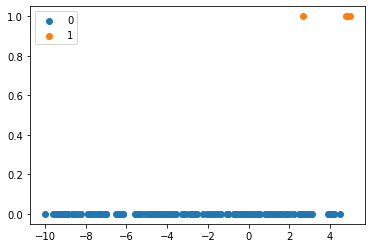

Models predictions


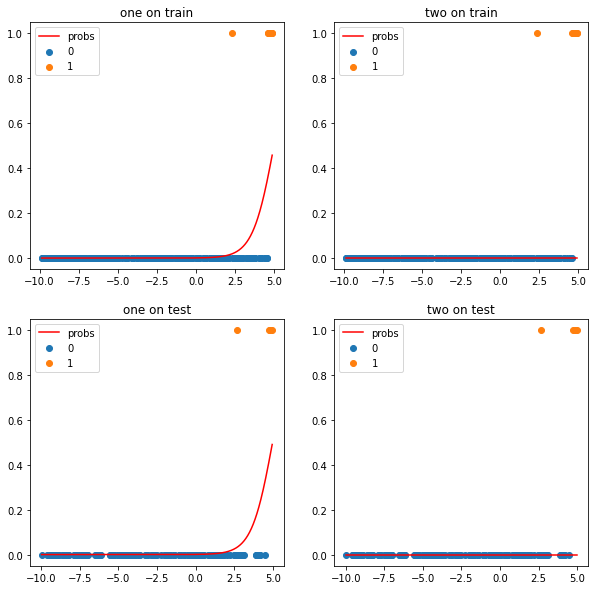

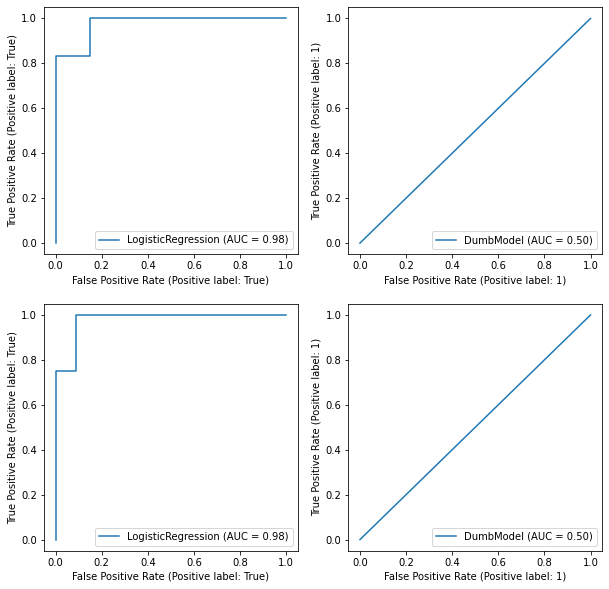

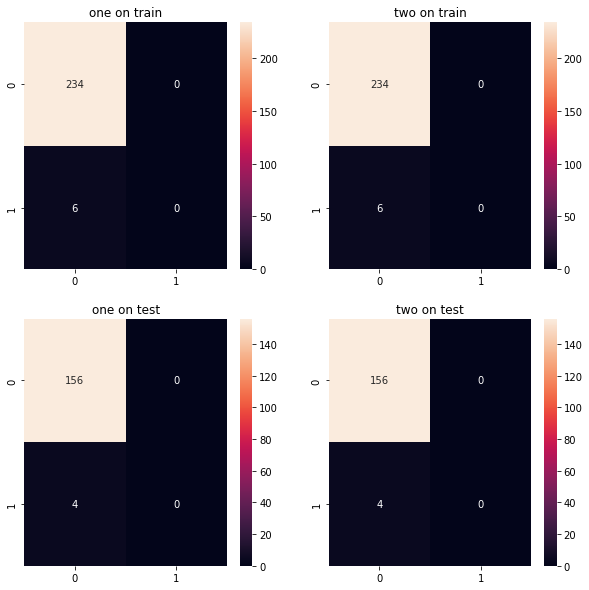

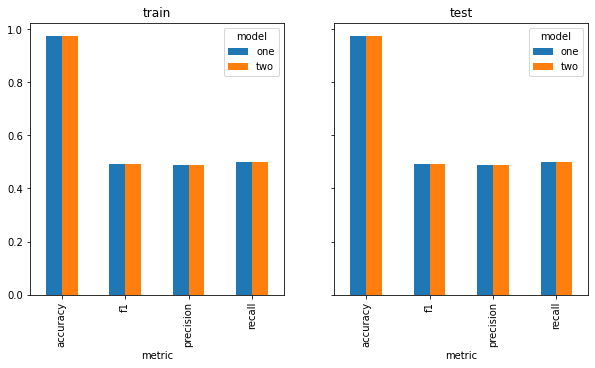

In [66]:
compare_models(LogisticRegression(random_state=1000), dumb_model, imbalanced_dataset)   # as simple as that

train set


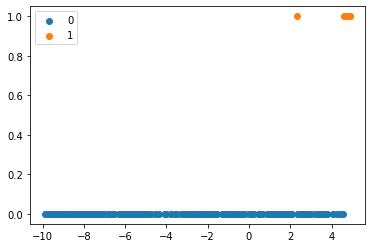

test set


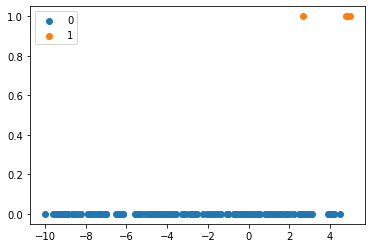

Models predictions


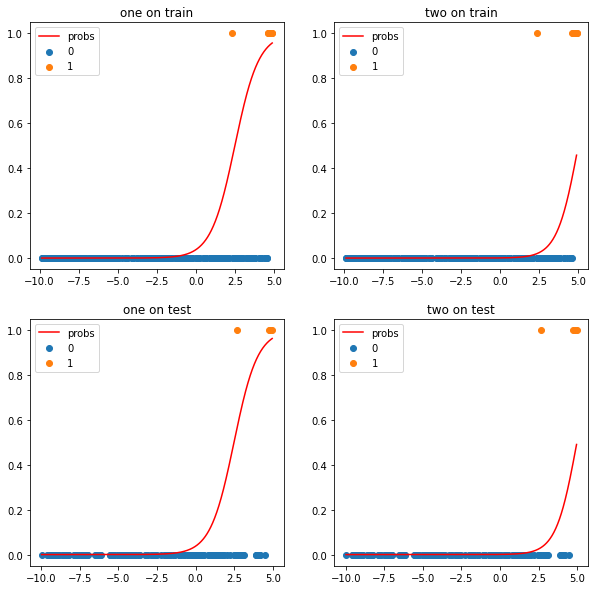

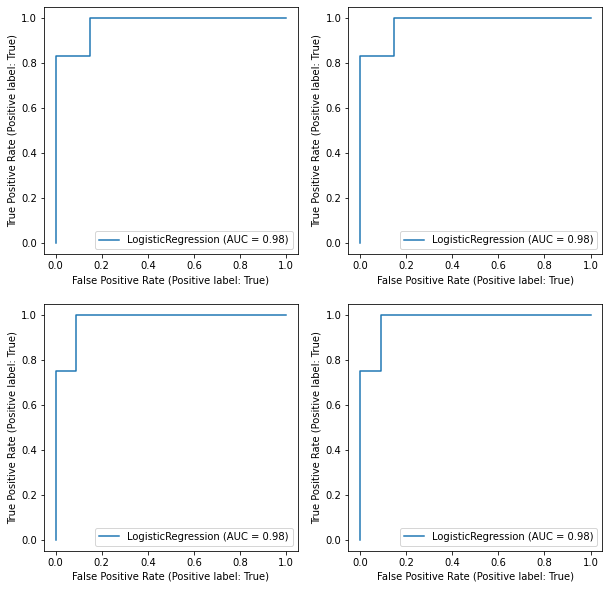

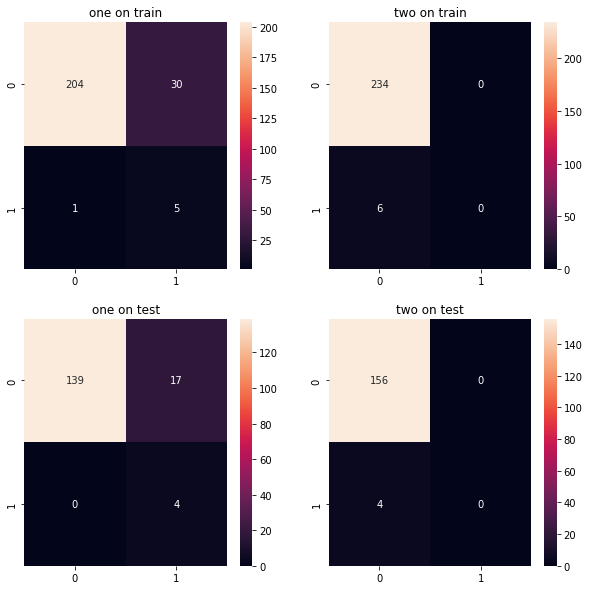

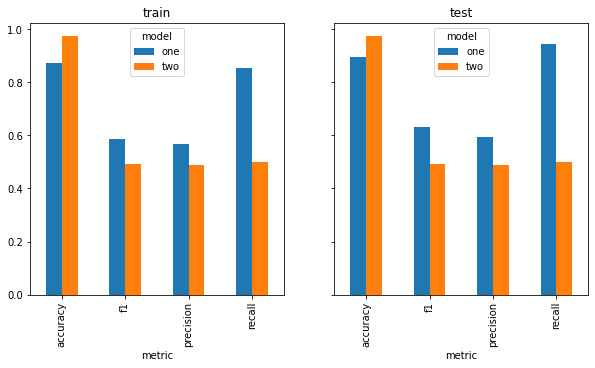

In [67]:
compare_models(LogisticRegression(class_weight='balanced', random_state=1000), LogisticRegression(random_state=1000), imbalanced_dataset)

train set


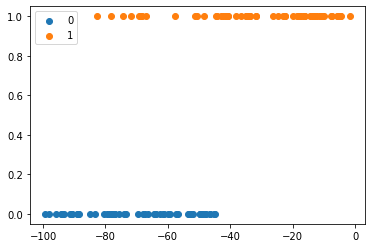

test set


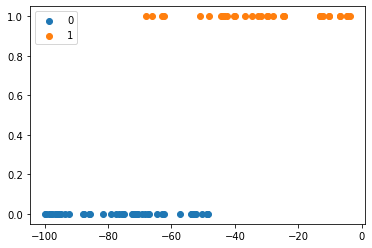

Models predictions


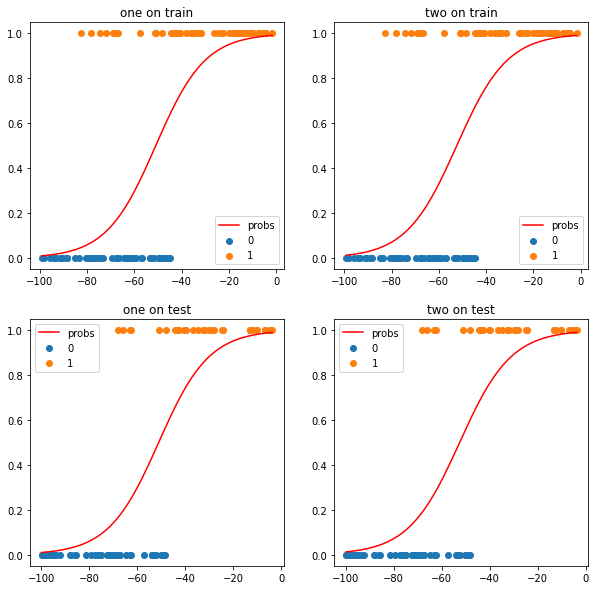

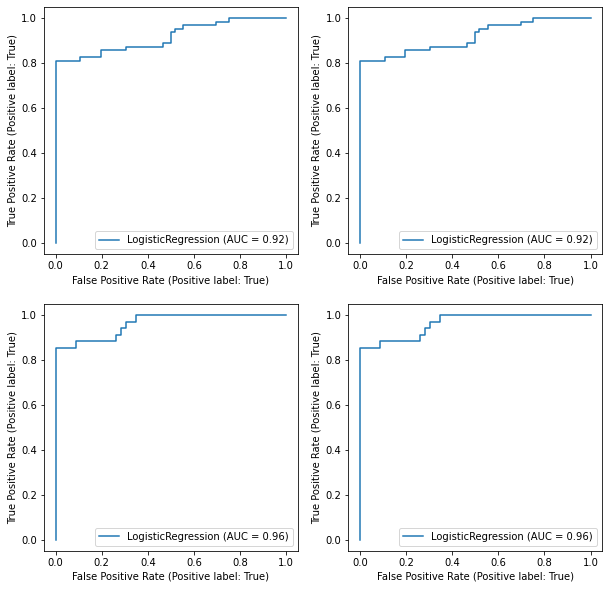

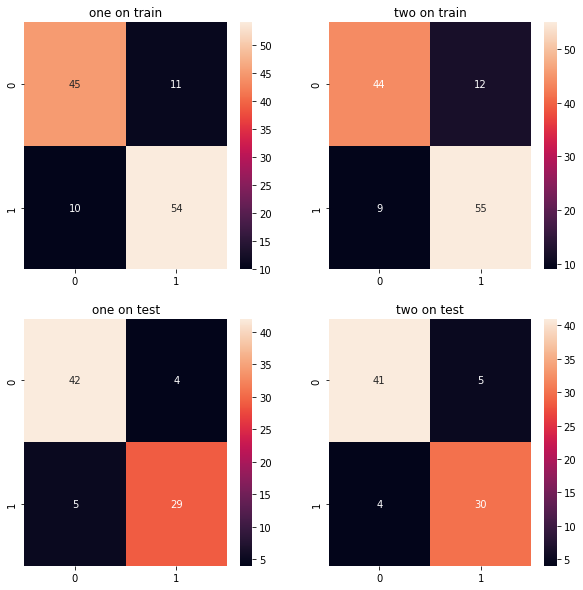

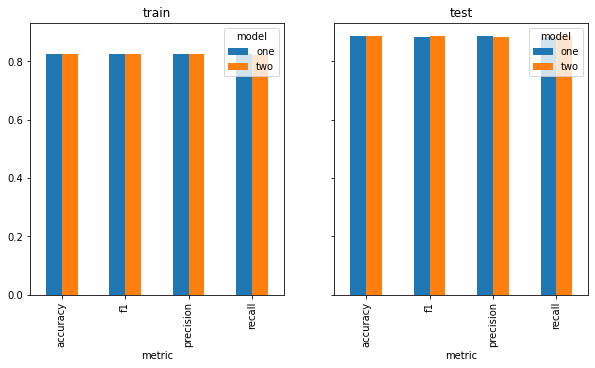

In [68]:
another_imbalanced_dataset = get_imbalanced_sample(200, 100, 100, 0.40) # let's try something else
compare_models(LogisticRegression(class_weight='balanced', random_state=1000), LogisticRegression(random_state=1000), another_imbalanced_dataset)

# Multi-Class Classification and the overfitting and underfitting problem

[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
[How it's Made](https://www.youtube.com/watch?v=_L39rN6gz7Y&ab_channel=StatQuestwithJoshStarmer)
![DecisionTreeClassifier visualised](decision_tree.png)

In [69]:
from sklearn.datasets import load_iris  # a classic
from sklearn.tree import DecisionTreeClassifier
data = load_iris(as_frame=True)
# we need to add some noise to the dataset, bcoz it's too clean and too good
X = pd.DataFrame(data.data+np.random.rand(*data.data.shape)*4, columns=data.feature_names)
y = pd.DataFrame(data.target.T, columns=['target'])
df = pd.concat((X, y), axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.969180,4.434380,3.911687,0.350358,0
1,7.329251,5.615891,5.168255,2.565582,0
2,8.435227,3.537070,1.554636,3.961983,0
3,6.126399,5.636286,5.192583,0.229553,0
4,5.541300,6.932783,1.732226,3.882058,0


In [70]:
y.value_counts()    # 3 classes!

target
0         50
1         50
2         50
dtype: int64

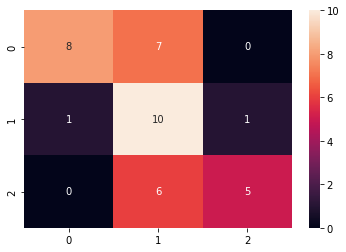

Accuracy: 0.6052631578947368
Precision: 0.7190016103059581
Recall: 0.6070707070707071
F1 score: 0.6087768440709618


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
train_df = pd.concat((X_train, y_train), axis=1)
test_df = pd.concat((X_test, y_test), axis=1)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)
show_metrics(model, test_df, target='target')

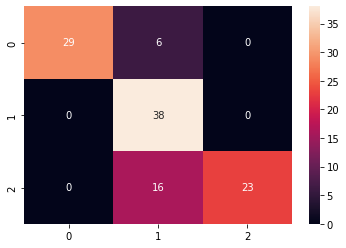

Accuracy: 0.8035714285714286
Precision: 0.8777777777777778
Recall: 0.8061050061050062
F1 score: 0.8078985626508667


In [72]:
show_metrics(model, train_df, target='target')

## Overfitting and underfitting apply in here as well

Models predictions


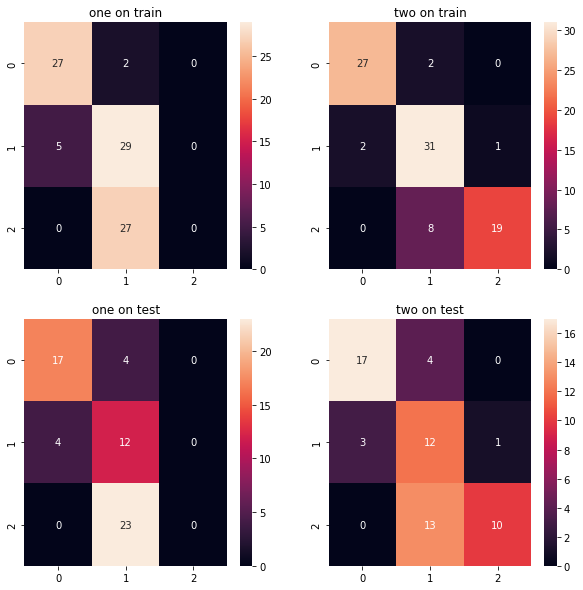

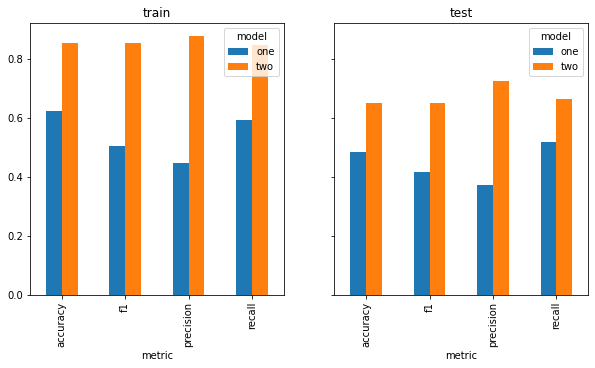

In [73]:
compare_models(DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3), df, target='target')

Models predictions


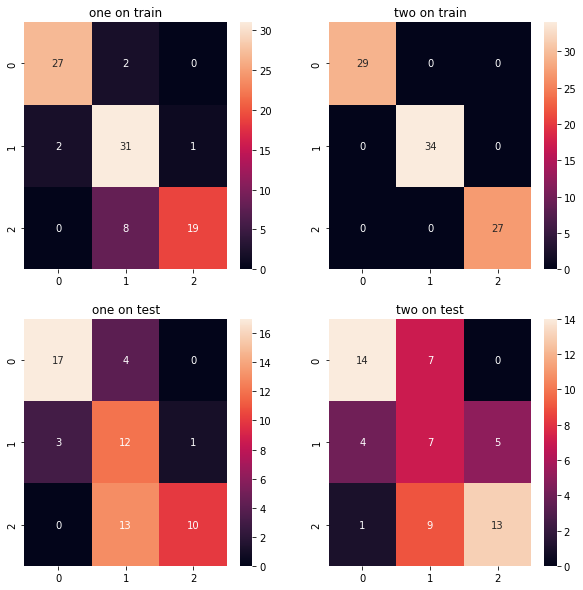

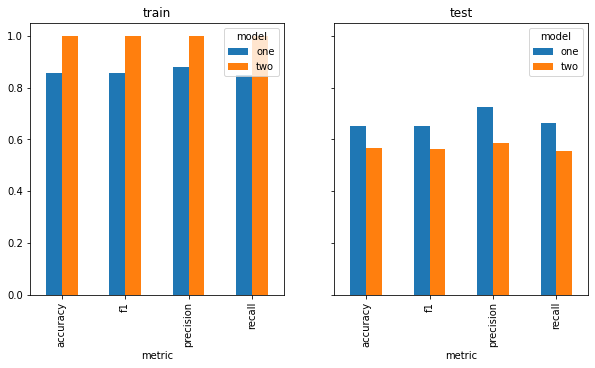

In [74]:
compare_models(DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=10), df, target='target')